In [1]:
import os
from pathlib import Path
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits

train_dataset = MNIST(
    root=Path('./tmp/'),
    download=True,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

test_dataset = MNIST(
    root=Path('./tmp/'),
    train=False,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)


def build_optim(model,optim,lr):
    optimizers = {
        'sgd':torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4),
        'adam':torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
        'adamw': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4),
        'rmsprop': torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=5e-4)
    }
    return optimizers[optim]

# def lrs(batch):
#     low = math.log2(1e-5)
#     high = math.log2(10)
#     return 2**(low+(high-low)*batch/len(train_dataloader)/gpc.config.NUM_EPOCHS)



# lr_scheduler
def build_lr_sch(optimizer,lr_sch):
    lr_schs = { #'lambda': torch.optim.lr_scheduler.LambdaLR(optimizer, lrs),
                'exp': torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9),
                'multistep':torch.optim.lr_scheduler.MultiStepLR(optimizer,[10,20],0.35)}
    return lr_schs[lr_sch]


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-labels-idx1-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to tmp/MNIST/raw



In [2]:
# train and val
import numpy as np
from torch.utils.data.dataloader import DataLoader


def train(optim,lr_sch,lr):

    model = LeNet5(n_classes=10)
    optimizer = build_optim(model,optim,lr)
    if lr_sch:
        lr_scheduler = build_lr_sch(optimizer,lr_sch)
    train_loader = DataLoader(train_dataset, 128, shuffle=True)
    test_loader = DataLoader(test_dataset, 128, shuffle=False)

    dataloaders = {'train':train_loader, 'test':test_loader}
    criterion = torch.nn.CrossEntropyLoss()

    model.cuda()

    records = {'train':{'loss':[],'acc':[]},'test':{'loss':[],'acc':[]}}

    for epoch in range(30):
        
        for mode in ['train','test']:
            if mode == 'train':
                model.train()
            else:
                model.eval()

            loss_epoch, acc_epoch = [], 0
            for iter, batch in enumerate(dataloaders[mode]):
                x, y = batch
                x = x.cuda()
                y = y.cuda()
                logits = model(x)
                loss = criterion(logits, y)
                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                loss_epoch.append(loss.item())
                acc_epoch += (y == torch.argmax(logits,dim=-1)).sum().item()
            loss_epoch = np.mean(loss_epoch)
            acc_epoch /= len(dataloaders[mode].dataset)
            print('[{}] Epoch {} Acc@1 {} Loss {}'.format(mode,epoch,round(acc_epoch,3),round(loss_epoch,3)))
            records[mode]['loss'].append(loss_epoch)
            records[mode]['acc'].append(acc_epoch)
            if lr_sch:
                lr_scheduler.step()

    return records
              

In [3]:
# optim, lr_sch = 'sgd', 'exp'
lrs_dict = {'sgd':[0.0001,0.2,0.5],'adam':[2e-5,0.005,0.05],'rmsprop':[2e-5,0.006,0.05]}
records_dict = {}
for optim,lr_list in lrs_dict.items():

    for i, lr in enumerate(lr_list):

        if i != 1: # not the best lr 
            lr_scheduler = [None]
        else:
            lr_scheduler = [None, 'exp']

        for lr_sch in lr_scheduler:
            records = train(optim,lr_sch,lr)
            key = (optim,lr,lr_sch)
            records_dict[key] = records

[train] Epoch 0 Acc@1 0.07 Loss 2.308
[test] Epoch 0 Acc@1 0.069 Loss 2.304
[train] Epoch 1 Acc@1 0.113 Loss 2.302
[test] Epoch 1 Acc@1 0.149 Loss 2.299
[train] Epoch 2 Acc@1 0.169 Loss 2.297
[test] Epoch 2 Acc@1 0.182 Loss 2.293
[train] Epoch 3 Acc@1 0.186 Loss 2.291
[test] Epoch 3 Acc@1 0.196 Loss 2.287
[train] Epoch 4 Acc@1 0.202 Loss 2.284
[test] Epoch 4 Acc@1 0.221 Loss 2.279
[train] Epoch 5 Acc@1 0.23 Loss 2.276
[test] Epoch 5 Acc@1 0.26 Loss 2.27
[train] Epoch 6 Acc@1 0.287 Loss 2.265
[test] Epoch 6 Acc@1 0.354 Loss 2.257
[train] Epoch 7 Acc@1 0.395 Loss 2.249
[test] Epoch 7 Acc@1 0.446 Loss 2.239
[train] Epoch 8 Acc@1 0.475 Loss 2.228
[test] Epoch 8 Acc@1 0.513 Loss 2.212
[train] Epoch 9 Acc@1 0.525 Loss 2.195
[test] Epoch 9 Acc@1 0.544 Loss 2.171
[train] Epoch 10 Acc@1 0.548 Loss 2.145
[test] Epoch 10 Acc@1 0.564 Loss 2.108
[train] Epoch 11 Acc@1 0.556 Loss 2.066
[test] Epoch 11 Acc@1 0.567 Loss 2.011
[train] Epoch 12 Acc@1 0.556 Loss 1.951
[test] Epoch 12 Acc@1 0.564 Loss 1.8

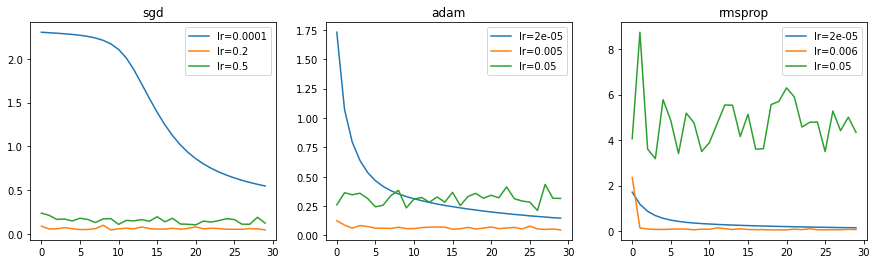

In [5]:
from IPython.core.pylabtools import figsize
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=[15,4])#, sharey='all')

for i,optim in enumerate(['sgd','adam','rmsprop']):
    
    for j,lr in enumerate(lrs_dict[optim]):
        x,y = list(range(30)), records_dict[(optim,lr,None)]['test']['loss']
        axs[i].plot(x, y, label='lr={}'.format(lr))
    axs[i].title.set_text(optim)
    axs[i].legend()
plt.show()

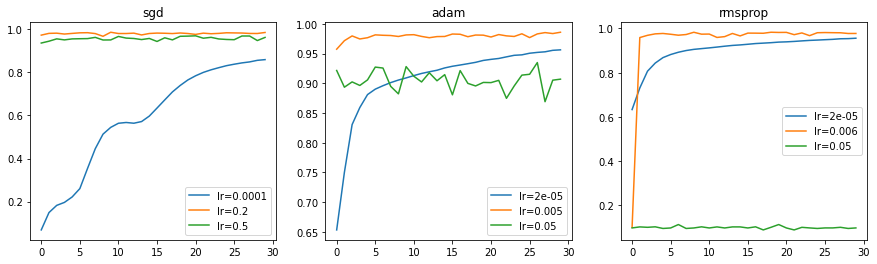

In [7]:
fig, axs = plt.subplots(1, 3, figsize=[15,4])#, sharey='all')
for i,optim in enumerate(['sgd','adam','rmsprop']):
    
    for j,lr in enumerate(lrs_dict[optim]):
        x,y = list(range(30)), records_dict[(optim,lr,None)]['test']['acc']
        axs[i].plot(x, y, label='lr={}'.format(lr))
    axs[i].title.set_text(optim)
    axs[i].legend()
plt.show()

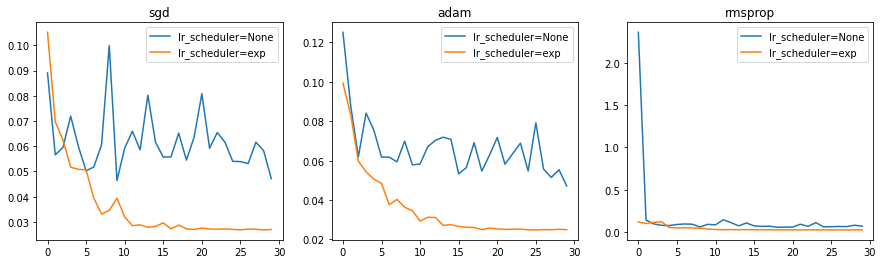

In [8]:
fig, axs = plt.subplots(1, 3, figsize=[15,4])#, sharey='all')

for i,optim in enumerate(['sgd','adam','rmsprop']):
    # fig = plt.figure(figsize=[10,6])
    for lr_sch in [None,'exp']:
        x,y = list(range(30)), records_dict[(optim,lrs_dict[optim][1],lr_sch)]['test']['loss']
        axs[i].plot(x, y, label='lr_scheduler={}'.format(lr_sch))
    axs[i].title.set_text(optim)
    axs[i].legend()
plt.show()

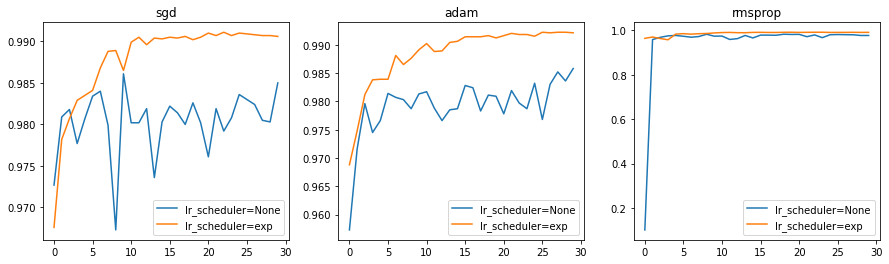

In [9]:
fig, axs = plt.subplots(1, 3, figsize=[15,4])#, sharey='all')

for i,optim in enumerate(['sgd','adam','rmsprop']):
    # fig = plt.figure(figsize=[10,6])
    for lr_sch in [None,'exp']:
        x,y = list(range(30)), records_dict[(optim,lrs_dict[optim][1],lr_sch)]['test']['acc']
        axs[i].plot(x, y, label='lr_scheduler={}'.format(lr_sch))
    axs[i].title.set_text(optim)
    axs[i].legend()
plt.show()

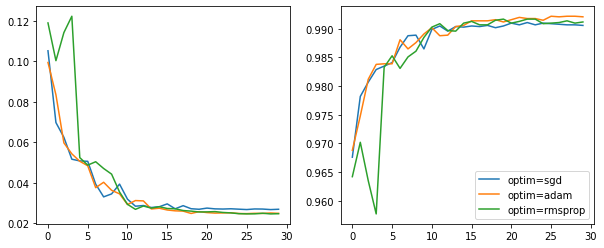

In [10]:
fig, axs = plt.subplots(1, 2, figsize=[10,4])#, sharey='all')
for i,optim in enumerate(['sgd','adam','rmsprop']):
    # fig = plt.figure(figsize=[10,6])
    for j, metric in enumerate(['loss','acc']):
        x,y = list(range(30)), records_dict[(optim,lrs_dict[optim][1],'exp')]['test'][metric]
        axs[j].plot(x, y, label='optim={}'.format(optim))
    axs[j].legend()
plt.show()